# Import and set colors

In [1]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm, colors
from gprofiler import gprofiler

import os 
#doublet detection
import scrublet as scr
#batch correction (not installed by default in the docker container, install via command line: pip install scanorama bbknn)
import scanorama as scan
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb
#for velocyti
import scvelo as scv

In [2]:
plt.rcParams['figure.figsize']=(4,4) #rescale figures
sc.settings.verbosity = 3
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=300,transparent=False, fontsize=12, color_map='plasma')
sc.logging.print_header()

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.22.3 scipy==1.8.0 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.4


In [3]:
#Define a nice colour map for gene expression
colors2 = plt.cm.plasma(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap2 = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [4]:
pair= [ "#DA0AD3", "#ED99BD",  "#FD3F14", "#ffbf00", 
       "#66B032", "#66B032", "#9AD255", "#9AD255",
       "#b30047",   "#dada2b", "#dada2b"]

# Set project file paths

In [5]:
file_path = '/Volumes/Seagate_Exp/Paper_sc_analysis/notebooks/analysis_early_time_points/040522_corrected_notebooks/Revision/'
#this is my file path please adapt it to your directory

In [6]:
data_dir =file_path +  'data/' 

In [7]:
table_dir = file_path + 'tables/230831diffxpy/'

In [8]:
sc.settings.figdir = file_path + 'figures/'

In [9]:
import datetime

today = datetime.date.today().strftime('%y%m%d') #creates a YYMMDD string of today's date

# Read Data & downstream analysis

In [10]:
adata_all_oligos=sc.read(data_dir + "230808adata_treated_oligos_proc_scVI.h5ad")

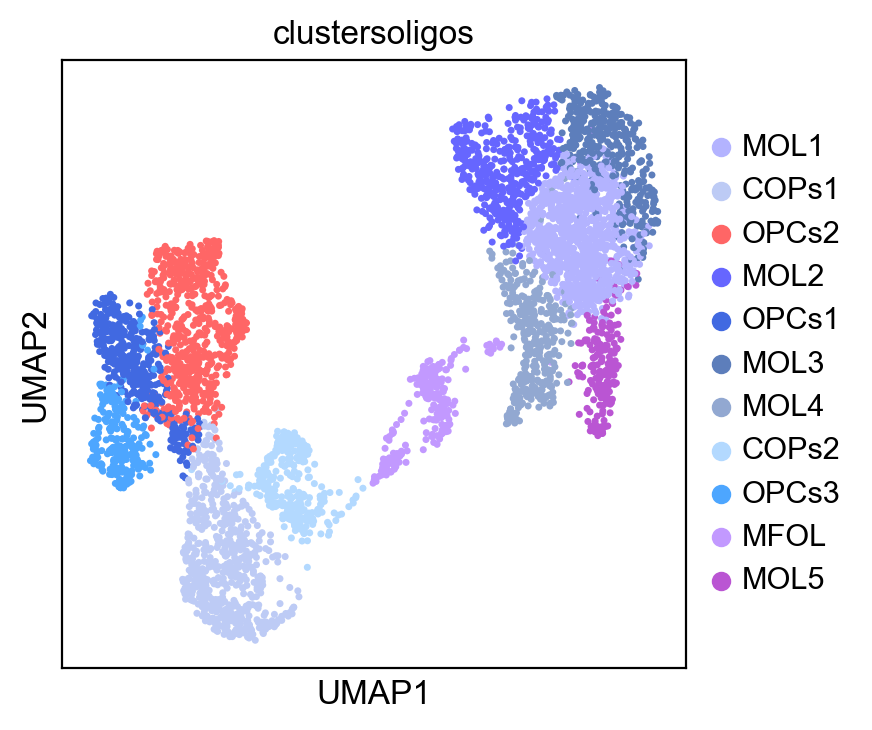

In [11]:
sc.pl.umap(adata_all_oligos, color='clustersoligos')

In [12]:
adata_all_oligos_3dpi= adata_all_oligos[np.in1d(adata_all_oligos.obs['condition'], 
                           ['3dpi_CTRL','3dpi_INH'])].copy()

In [13]:
import batchglm.api as glm
import diffxpy.api as de

print("batchglm version "+glm.__version__)
print("diffpy version "+de.__version__)
from batchglm.pkg_constants import TF_CONFIG_PROTO

batchglm version v0.7.4
diffpy version v0.7.4


In [14]:
#Set number of threads
TF_CONFIG_PROTO.inter_op_parallelism_threads = 1
TF_CONFIG_PROTO.intra_op_parallelism_threads = 12

# 3dpi

In [15]:
adata_all_oligos_3dpi.obs['clustersoligos'].value_counts()*0.1

OPCs2    34.7
OPCs1    21.3
MOL1     19.2
MOL2      7.1
OPCs3     6.7
COPs1     6.6
MOL4      5.0
MOL5      3.7
MFOL      1.8
COPs2     1.4
MOL3      0.6
Name: clustersoligos, dtype: float64

In [16]:
adata_all_oligos_3dpi_OPCs1= adata_all_oligos_3dpi[np.in1d(adata_all_oligos_3dpi.obs['clustersoligos'], 
                           ['OPCs1'])].copy()

In [17]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata_all_oligos_3dpi_OPCs1.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_all_oligos_3dpi_OPCs1, min_cells=21)
print('Number of genes after cell filter: {:d}'.format(adata_all_oligos_3dpi_OPCs1.n_vars))

Total number of genes: 14250
filtered out 6782 genes that are detected in less than 21 cells
Number of genes after cell filter: 7468


In [18]:
adata_all_oligos_3dpi_OPCs2= adata_all_oligos_3dpi[np.in1d(adata_all_oligos_3dpi.obs['clustersoligos'], 
                           ['OPCs2'])].copy()

In [19]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata_all_oligos_3dpi_OPCs2.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_all_oligos_3dpi_OPCs2, min_cells=35)
print('Number of genes after cell filter: {:d}'.format(adata_all_oligos_3dpi_OPCs2.n_vars))

Total number of genes: 14250
filtered out 4883 genes that are detected in less than 35 cells
Number of genes after cell filter: 9367


In [20]:
adata_all_oligos_3dpi_MOL1= adata_all_oligos_3dpi[np.in1d(adata_all_oligos_3dpi.obs['clustersoligos'], 
                           ['MOL1'])].copy()

In [21]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata_all_oligos_3dpi_MOL1.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_all_oligos_3dpi_MOL1, min_cells=19)
print('Number of genes after cell filter: {:d}'.format(adata_all_oligos_3dpi_MOL1.n_vars))

Total number of genes: 14250
filtered out 8941 genes that are detected in less than 19 cells
Number of genes after cell filter: 5309


# Cluster OPCs1

In [22]:
difxpy_reactiveoligos_3dpi_INHvsCTRL_OPCs1= de.test.wald(
    data=adata_all_oligos_3dpi_OPCs1.layers['counts'].toarray(), #need the counts for the test
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition",
    gene_names=adata_all_oligos_3dpi_OPCs1.var_names,
    sample_description=adata_all_oligos_3dpi_OPCs1.obs
)

training location model: False
training scale model: True
iter   0: ll=41079473.740366
iter   1: ll=41079473.740366, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=1464475.855341, converged: 0.71% (loc: 0.71%, scale update: True), in 13.04sec
iter   3: ll=1464475.855341, converged: 0.71% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=1260122.370378, converged: 82.23% (loc: 82.23%, scale update: True), in 11.68sec
iter   5: ll=1260122.370378, converged: 82.23% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=1239589.577287, converged: 95.69% (loc: 95.69%, scale update: True), in 6.64sec
iter   7: ll=1239589.577287, converged: 95.69% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=1236061.781146, converged: 99.29% (loc: 99.29%, scale update: True), in 5.45sec
iter   9: ll=1236061.781146, converged: 99.29% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=1235797.531573, converged: 99.95% (loc: 99.95%, scale 

Order test results by q-value:

In [23]:
difxpy_reactiveoligos_3dpi_INHvsCTRL_OPCs1.summary().sort_values('qval', ascending=True).iloc[:10,:]

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
3378,Hbb-bs,5.324599e-10,0.000004,-1.191720,3.051643,False,2.244517e-08,-1.191720,0.191927,-452.778005
5097,Hba-a1,1.307167e-04,0.389070,-1.117801,0.920188,False,1.808267e-08,-1.117801,0.292228,-251.386523
5098,Hba-a2,1.910408e-04,0.389070,-1.113677,0.657277,False,5.192329e-10,-1.113677,0.298527,-214.356243
5920,Acp1,2.083933e-04,0.389070,0.510267,1.765258,False,5.209711e-09,0.510267,0.137589,-354.058663
4077,Uba52,2.904736e-04,0.433851,0.566069,1.821596,False,1.533999e-09,0.566069,0.156215,-374.265180
726,Slc1a2,4.701644e-04,0.438898,0.575567,1.657277,False,3.817910e-09,0.575567,0.164579,-361.016852
2893,Camk1,4.195606e-04,0.438898,0.470158,1.873239,False,6.695900e-09,0.470158,0.133285,-360.889995
7367,Ifit3b,4.195549e-04,0.438898,-1.409444,0.173709,False,2.764707e-10,-1.409444,0.399562,-96.836327
5334,Zfp207,7.188131e-04,0.447341,-0.461931,1.206573,False,3.294718e-09,-0.461931,0.136573,-305.683675
2672,Ptprz1,6.131986e-04,0.447341,0.261833,14.065728,False,8.717282e-10,0.261833,0.076432,-702.103885


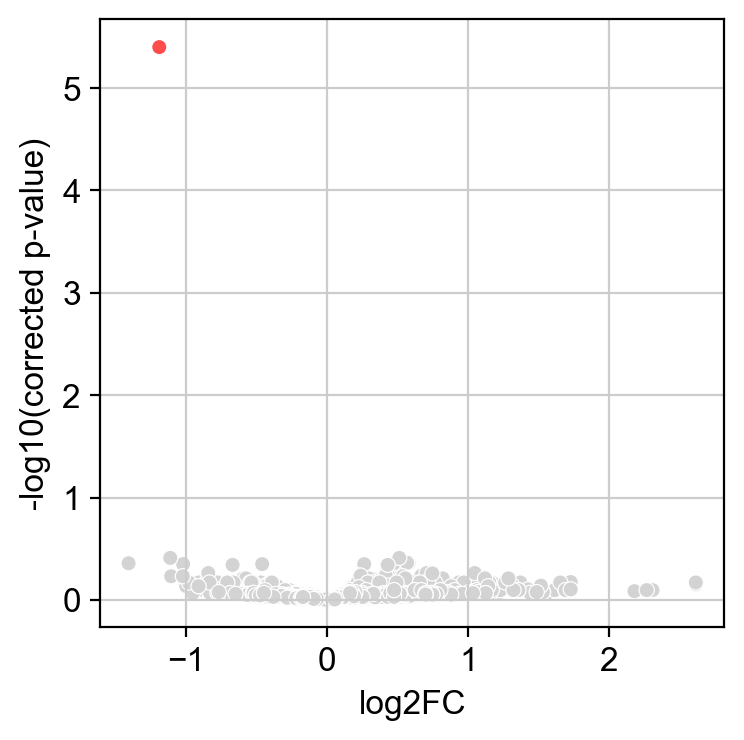

In [24]:
difxpy_reactiveoligos_3dpi_INHvsCTRL_OPCs1.plot_volcano(corrected_pval=True, min_fc=2.0, alpha=0.05, size=30)

Save results to file.

In [25]:
difxpy_reactiveoligos_3dpi_INHvsCTRL_OPCs1.summary().to_csv(table_dir+today + 'difxpy_reactiveoligos_3dpi_INHvsCTRL_OPCs1.csv')

In [26]:
today

'230831'

In [27]:
difxpy_3dpi_INHvsCTRL_OPCs1 = pd.read_csv(table_dir + '230831difxpy_reactiveoligos_3dpi_INHvsCTRL_OPCs1.csv', index_col=0)

In [28]:
#Visualise your top 10 DE genes in a heatmap/matrixplot/dotplot.
difxpy_3dpi_INHvsCTRL_expressed_OPCs1=difxpy_3dpi_INHvsCTRL_OPCs1.loc[difxpy_3dpi_INHvsCTRL_OPCs1['mean']>0.2]

In [29]:
difxpy_3dpi_INHvsCTRL_expressed_OPCs1

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,Mrpl15,0.054190,0.855451,-0.319489,0.765258,False,1.174987e-09,-0.319489,0.165941,-245.522793
1,Lypla1,0.503032,0.949607,-0.192461,0.258216,False,6.489582e-04,-0.192461,0.287372,-131.769393
2,Tcea1,0.325331,0.936124,0.205024,0.647887,False,1.229049e-09,0.205024,0.208450,-230.004495
4,Atp6v1h,0.743593,0.979920,0.085522,0.366197,False,9.096780e-10,0.085522,0.261457,-166.357345
5,Rb1cc1,0.390895,0.938295,0.236899,0.370892,False,3.015019e-09,0.236899,0.276107,-168.584710
...,...,...,...,...,...,...,...,...,...,...
7462,mt-Nd4,0.069403,0.859927,0.180126,12.549296,False,2.026520e-08,0.180126,0.099200,-721.501811
7463,mt-Nd5,0.257538,0.923132,0.189712,1.525822,False,3.709445e-09,0.189712,0.167557,-355.666632
7464,mt-Cytb,0.081464,0.859927,0.160672,24.201878,False,6.701380e-08,0.160672,0.092221,-848.964109
7465,Vamp7,0.745959,0.979920,0.064245,0.600939,False,5.166850e-03,0.064245,0.198303,-211.708758


In [30]:
#Extract the significant differentially expressed genes from the test.summary() table and split the list into higher expressed in cortex and higher expressed in substantia nigra.
difxpy_3dpi_INHvsCTRL_expressed_signif_OPCs1 = difxpy_3dpi_INHvsCTRL_expressed_OPCs1.loc[difxpy_3dpi_INHvsCTRL_expressed_OPCs1['pval']<0.05]

In [31]:
#Filter for a minimum mean expression of 0.05 (or choose your own threshold).
oligos_3dpi_INH_OPCs1 = difxpy_3dpi_INHvsCTRL_expressed_signif_OPCs1.loc[difxpy_3dpi_INHvsCTRL_expressed_signif_OPCs1['log2fc']>0.7]
oligos_3dpi_CTRL_OPCs1 = difxpy_3dpi_INHvsCTRL_expressed_signif_OPCs1.loc[difxpy_3dpi_INHvsCTRL_expressed_signif_OPCs1['log2fc']<-0.7]

In [32]:
oligos_3dpi_INH_OPCs1.shape

(68, 10)

In [33]:
oligos_3dpi_CTRL_OPCs1.shape

(11, 10)

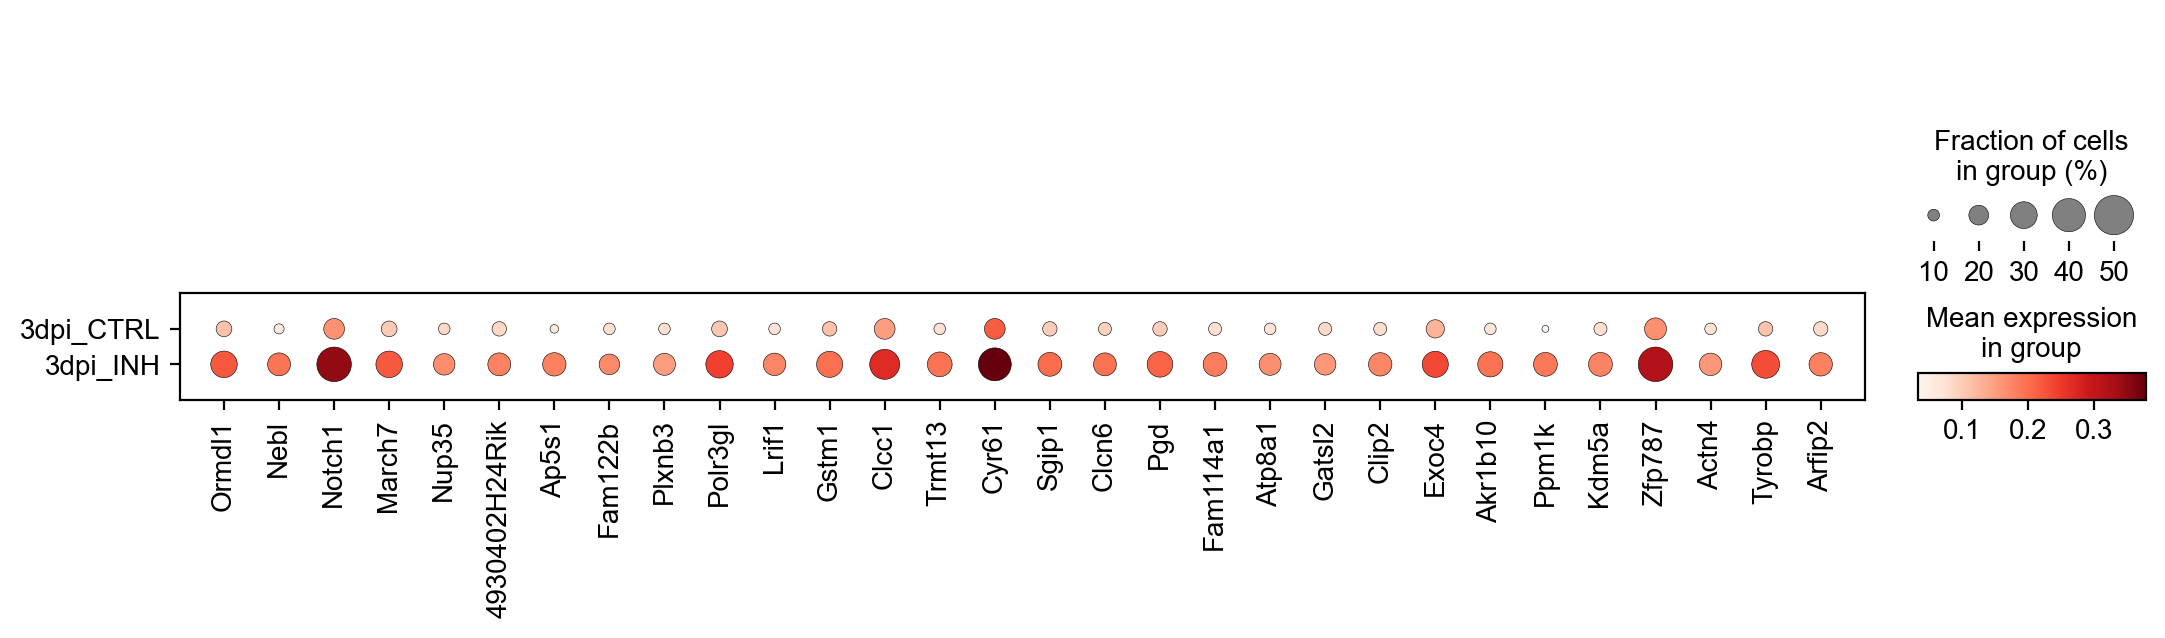

In [34]:
sc.pl.dotplot(adata_all_oligos_3dpi_OPCs1,oligos_3dpi_INH_OPCs1['gene'].head(30) , groupby='condition',)

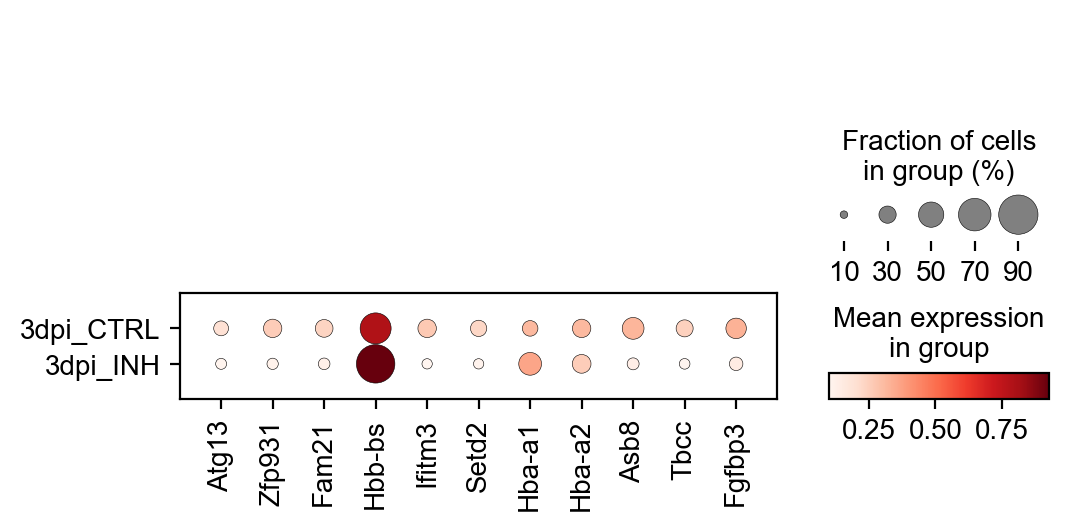

In [35]:
sc.pl.dotplot(adata_all_oligos_3dpi_OPCs1,oligos_3dpi_CTRL_OPCs1['gene'].head(30) , groupby='condition',)

# Cluster OPCs2

In [36]:
difxpy_reactiveoligos_3dpi_INHvsCTRL_OPCs2= de.test.wald(
    data=adata_all_oligos_3dpi_OPCs2.layers['counts'].toarray(), #need the counts for the test
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition",
    gene_names=adata_all_oligos_3dpi_OPCs2.var_names,
    sample_description=adata_all_oligos_3dpi_OPCs2.obs
)

training location model: False
training scale model: True
iter   0: ll=14487020.910012
iter   1: ll=14487020.910012, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=3717765.011933, converged: 0.18% (loc: 0.18%, scale update: True), in 13.53sec
iter   3: ll=3717765.011933, converged: 0.18% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=3664854.353358, converged: 96.00% (loc: 96.00%, scale update: True), in 13.37sec
iter   5: ll=3664854.353358, converged: 96.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=3659289.860599, converged: 99.06% (loc: 99.06%, scale update: True), in 5.85sec
iter   7: ll=3659289.860599, converged: 99.06% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=3658158.488609, converged: 99.83% (loc: 99.83%, scale update: True), in 5.49sec
iter   9: ll=3658158.488609, converged: 99.83% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=3658158.488609, converged: 100.00% (loc: 100.00%, scal

Order test results by q-value:

In [37]:
difxpy_reactiveoligos_3dpi_INHvsCTRL_OPCs2.summary().sort_values('qval', ascending=True).iloc[:10,:]

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
4221,Hbb-bs,1.041389e-13,9.754693e-10,-1.139739,6.429395,False,6.690583e-08,-1.139739,0.153281,-955.124058
8163,Rtp4,3.617107e-13,1.694072e-09,-1.053389,2.135447,False,5.027004e-09,-1.053389,0.144912,-655.296858
6387,Irgm1,2.344347e-12,7.319833e-09,-0.962663,2.674352,False,2.313852e-09,-0.962663,0.137282,-722.638428
6577,Xaf1,4.202860e-12,9.842048e-09,-1.654906,0.841499,False,6.534212e-09,-1.654906,0.238797,-402.231634
5569,Psme2,7.221335e-12,1.352845e-08,-0.731105,2.265130,False,9.124093e-09,-0.731105,0.106681,-662.987552
4412,Ifitm3,8.267276e-11,1.290660e-07,-1.270561,6.170029,False,4.522079e-09,-1.270561,0.195602,-883.102402
1473,Maged1,1.096621e-10,1.467435e-07,-0.725257,8.484150,False,1.297419e-08,-0.725257,0.112391,-1089.757074
994,B2m,2.188179e-10,2.562084e-07,-0.621728,18.322767,False,7.941044e-10,-0.621728,0.097948,-1342.766134
8550,Psmb8,8.063759e-10,7.292199e-07,-0.932768,2.625360,False,1.719888e-09,-0.932768,0.151826,-715.740110
6361,Hba-a2,8.512482e-10,7.292199e-07,-1.477853,2.181556,False,9.452196e-09,-1.477853,0.240886,-541.951889


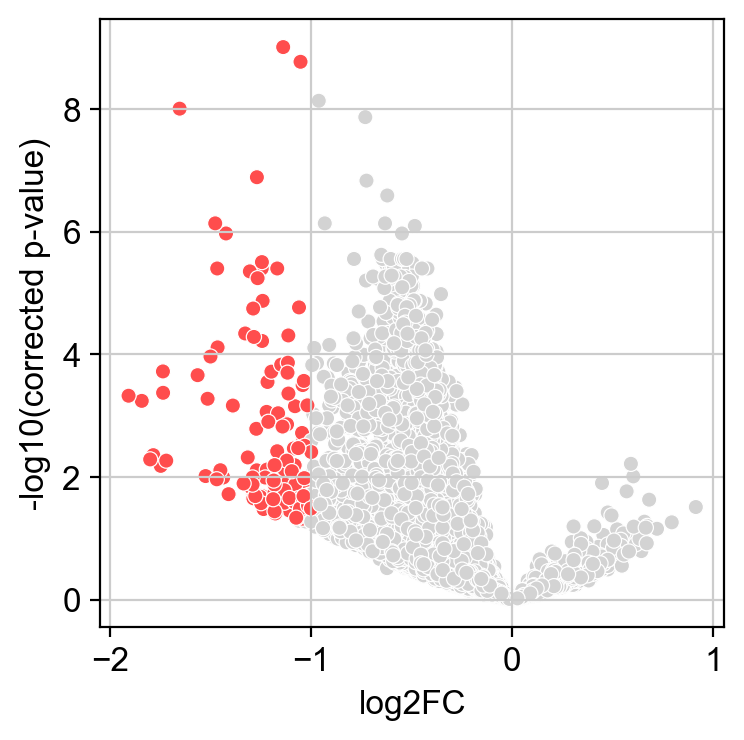

In [38]:
difxpy_reactiveoligos_3dpi_INHvsCTRL_OPCs2.plot_volcano(corrected_pval=True, min_fc=2.0, alpha=0.05, size=30)

Save results to file.

In [39]:
difxpy_reactiveoligos_3dpi_INHvsCTRL_OPCs2.summary().to_csv(table_dir+today + 'difxpy_reactiveoligos_3dpi_INHvsCTRL_OPCs2.csv')

In [40]:
today

'230831'

In [41]:
difxpy_3dpi_INHvsCTRL_OPCs2 = pd.read_csv(table_dir + '230831difxpy_reactiveoligos_3dpi_INHvsCTRL_OPCs2.csv', index_col=0)

In [42]:
#Visualise your top 10 DE genes in a heatmap/matrixplot/dotplot.
difxpy_3dpi_INHvsCTRL_expressed_OPCs2=difxpy_3dpi_INHvsCTRL_OPCs2.loc[difxpy_3dpi_INHvsCTRL_OPCs2['mean']>0.2]

In [43]:
difxpy_3dpi_INHvsCTRL_expressed_OPCs2

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,Mrpl15,0.001635,0.010349,-0.383140,1.559078,False,1.455397e-08,-0.383140,0.121649,-582.640576
1,Lypla1,0.106273,0.212644,-0.247826,0.573487,False,1.299406e-09,-0.247826,0.153436,-347.350662
2,Tcea1,0.036947,0.100605,-0.269820,1.334294,False,9.308985e-09,-0.269820,0.129326,-546.601353
3,Rgs20,0.000035,0.000570,-0.768697,0.657061,False,6.905886e-10,-0.768697,0.185674,-377.285304
4,Atp6v1h,0.034541,0.095836,-0.312830,0.829971,False,3.422543e-09,-0.312830,0.148002,-431.215176
...,...,...,...,...,...,...,...,...,...,...
9362,mt-Nd5,0.007800,0.033137,-0.251422,3.334294,False,5.225920e-10,-0.251422,0.094499,-787.162162
9363,mt-Cytb,0.003584,0.018852,-0.219171,44.538905,False,3.260996e-08,-0.219171,0.075249,-1617.913353
9364,Vamp7,0.050065,0.123863,-0.240831,0.930836,False,4.543699e-10,-0.240831,0.122910,-443.910612
9365,PISD,0.312602,0.457278,-0.153895,0.605187,False,2.499164e-10,-0.153895,0.152404,-360.886996


In [44]:
#Extract the significant differentially expressed genes from the test.summary() table and split the list into higher expressed in cortex and higher expressed in substantia nigra.
difxpy_3dpi_INHvsCTRL_expressed_signif_OPCs2 = difxpy_3dpi_INHvsCTRL_expressed_OPCs2.loc[difxpy_3dpi_INHvsCTRL_expressed_OPCs2['pval']<0.05]

In [45]:
#Filter for a minimum mean expression of 0.05 (or choose your own threshold).
oligos_3dpi_INH_OPCs2 = difxpy_3dpi_INHvsCTRL_expressed_signif_OPCs2.loc[difxpy_3dpi_INHvsCTRL_expressed_signif_OPCs2['log2fc']>0.7]
oligos_3dpi_CTRL_OPCs2 = difxpy_3dpi_INHvsCTRL_expressed_signif_OPCs2.loc[difxpy_3dpi_INHvsCTRL_expressed_signif_OPCs2['log2fc']<-0.7]

In [46]:
oligos_3dpi_INH_OPCs2.shape

(0, 10)

In [47]:
oligos_3dpi_CTRL_OPCs2.shape

(304, 10)

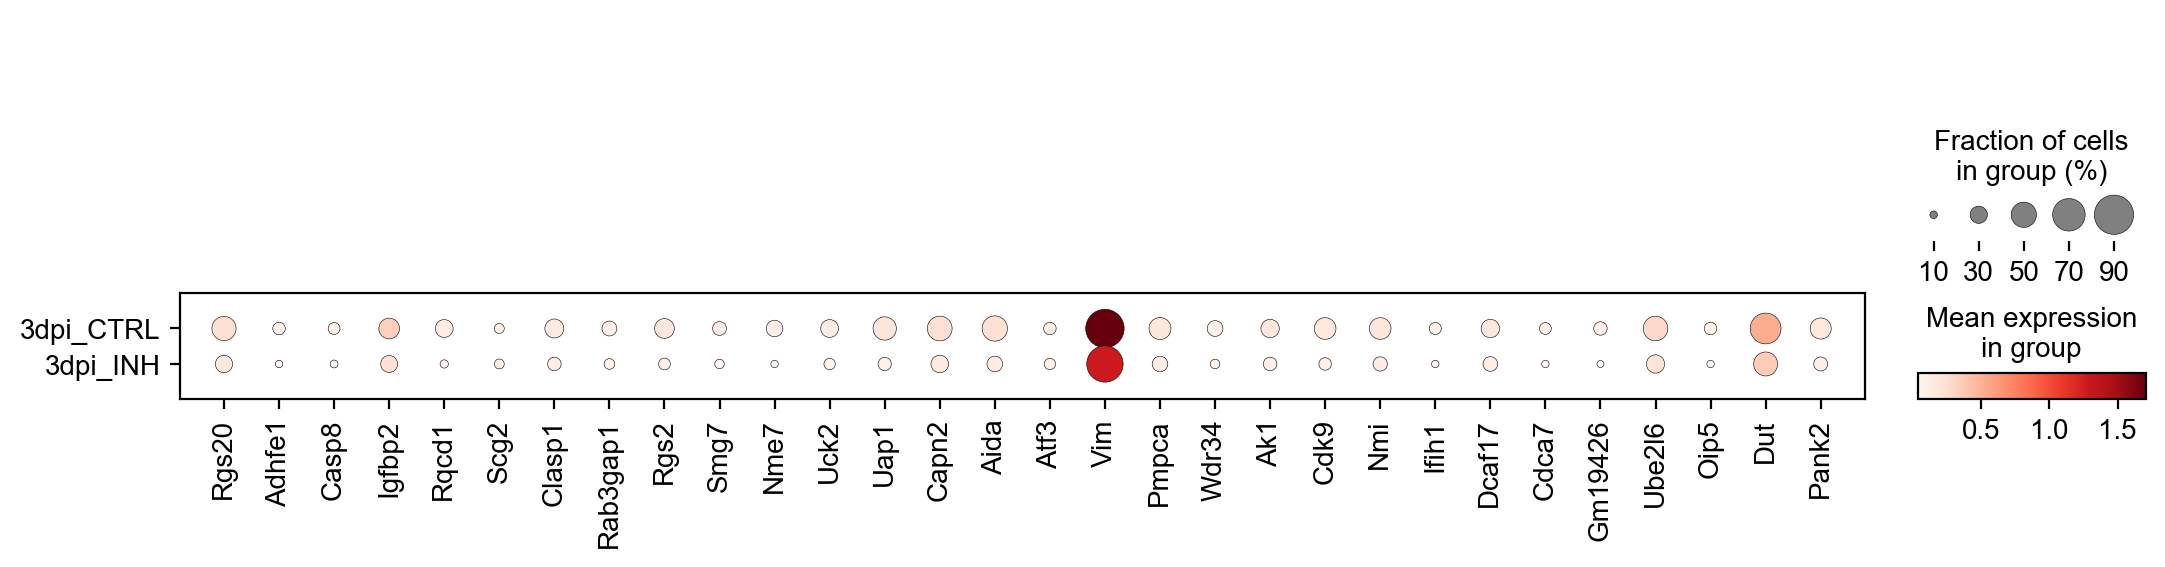

In [48]:
sc.pl.dotplot(adata_all_oligos_3dpi_OPCs2,oligos_3dpi_CTRL_OPCs2['gene'].head(30) , groupby='condition',)

# Cluster MOL1

In [49]:
difxpy_reactiveoligos_3dpi_INHvsCTRL_MOL1= de.test.wald(
    data=adata_all_oligos_3dpi_MOL1.layers['counts'].toarray(), #need the counts for the test
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition",
    gene_names=adata_all_oligos_3dpi_MOL1.var_names,
    sample_description=adata_all_oligos_3dpi_MOL1.obs
)

training location model: False
training scale model: True
iter   0: ll=60412368.801720
iter   1: ll=60412368.801720, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=897000.091798, converged: 0.60% (loc: 0.60%, scale update: True), in 10.73sec
iter   3: ll=897000.091798, converged: 0.60% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=745821.294312, converged: 70.35% (loc: 70.35%, scale update: True), in 9.89sec
iter   5: ll=745821.294312, converged: 70.35% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=722659.351398, converged: 92.71% (loc: 92.71%, scale update: True), in 6.53sec
iter   7: ll=722659.351398, converged: 92.71% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=718699.641126, converged: 98.70% (loc: 98.70%, scale update: True), in 5.29sec
iter   9: ll=718699.641126, converged: 98.70% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=718287.499011, converged: 99.81% (loc: 99.81%, scale update: Tr

Order test results by q-value:

In [50]:
difxpy_reactiveoligos_3dpi_INHvsCTRL_MOL1.summary().sort_values('qval', ascending=True).iloc[:10,:]

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
2986,Gm10073,0.0,0.0,283.913085,0.151042,False,0.260415,283.913085,2.222759e-162,-360.693119
1841,Slc25a13,0.0,0.0,283.913085,0.145833,False,0.249999,283.913085,2.222759e-162,-346.966606
1860,Snd1,0.0,0.0,283.913085,0.104167,False,0.197915,283.913085,2.222759e-162,-268.059507
239,Ncstn,0.0,0.0,283.913085,0.098958,False,0.294506,283.913085,2.222759e-162,-226.792910
4978,Nrxn1,0.0,0.0,283.913085,0.109375,False,0.208332,283.913085,2.222759e-162,-281.972470
3133,Dhrs4,0.0,0.0,283.913085,0.130208,False,0.239582,283.913085,2.222759e-162,-327.203352
3750,Rab11fip4,0.0,0.0,283.913085,0.125000,False,0.375970,283.913085,2.222759e-162,-292.037584
2848,Galnt7,0.0,0.0,283.913085,0.109375,False,0.331935,283.913085,2.222759e-162,-3.881697
290,G0s2,0.0,0.0,283.913085,0.104167,False,0.312250,283.913085,2.222759e-162,-24.221290
2604,Pfkl,0.0,0.0,283.913085,0.135417,False,0.239582,283.913085,2.222759e-162,-330.225568


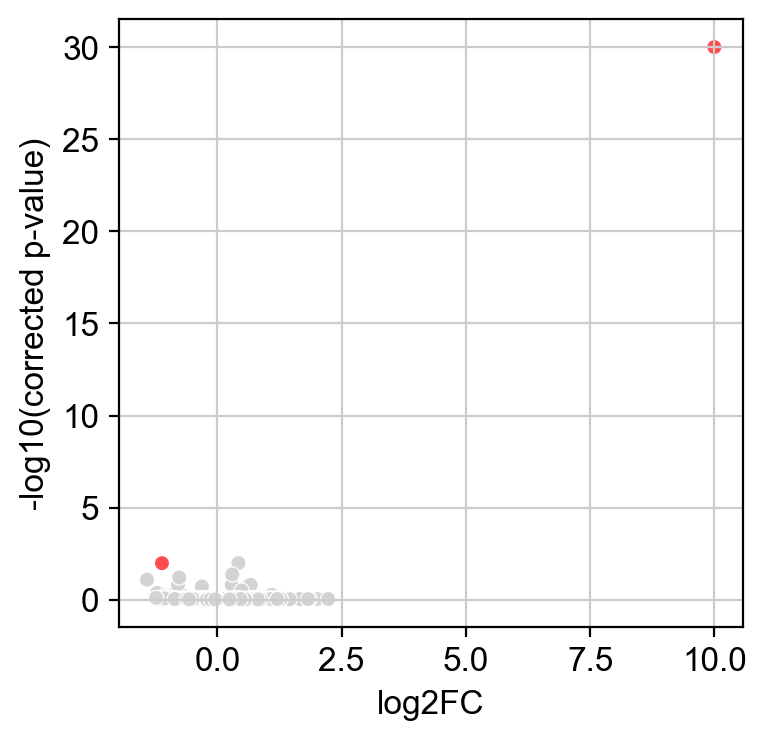

In [51]:
difxpy_reactiveoligos_3dpi_INHvsCTRL_MOL1.plot_volcano(corrected_pval=True, min_fc=2.0, alpha=0.05, size=30)

Save results to file.

In [52]:
difxpy_reactiveoligos_3dpi_INHvsCTRL_MOL1.summary().to_csv(table_dir+today + 'difxpy_reactiveoligos_3dpi_INHvsCTRL_MOL1.csv')

In [53]:
today

'230831'

In [54]:
difxpy_3dpi_INHvsCTRL_MOL1 = pd.read_csv(table_dir + '230831difxpy_reactiveoligos_3dpi_INHvsCTRL_MOL1.csv', index_col=0)

In [55]:
#Visualise your top 10 DE genes in a heatmap/matrixplot/dotplot.
difxpy_3dpi_INHvsCTRL_expressed_MOL1=difxpy_3dpi_INHvsCTRL_MOL1.loc[difxpy_3dpi_INHvsCTRL_MOL1['mean']>0.2]

In [56]:
difxpy_3dpi_INHvsCTRL_expressed_MOL1

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,Mrpl15,0.156601,0.933103,-0.333895,0.500000,False,1.479245e-01,-0.333895,0.235702,-36.599187
1,Tcea1,0.632917,0.969589,-0.103371,0.671875,False,6.661014e-01,-0.103371,0.216428,0.000000
2,Atp6v1h,0.835249,0.985604,-0.067266,0.307292,False,3.533283e-01,-0.067266,0.323435,-25.077646
3,Rb1cc1,0.539603,0.969589,0.272241,0.203125,False,1.647499e-02,0.272241,0.443813,-0.263885
4,St18,0.907053,0.988089,-0.031614,0.447917,False,1.661684e-01,-0.031614,0.270770,-16.848412
...,...,...,...,...,...,...,...,...,...,...
5304,mt-Nd4l,0.020677,0.903135,0.469600,1.203125,False,3.088736e-09,0.469600,0.202953,-273.650909
5305,mt-Nd4,0.367538,0.949889,-0.062390,15.218750,False,9.349271e-08,-0.062390,0.069238,-603.512023
5306,mt-Nd5,0.368254,0.949889,-0.137563,1.526042,False,4.822556e-09,-0.137563,0.152890,-304.924897
5307,mt-Cytb,0.426561,0.951814,-0.041999,30.937500,False,3.353993e-08,-0.041999,0.052823,-686.874809


In [57]:
#Extract the significant differentially expressed genes from the test.summary() table and split the list into higher expressed in cortex and higher expressed in substantia nigra.
difxpy_3dpi_INHvsCTRL_expressed_signif_MOL1 = difxpy_3dpi_INHvsCTRL_expressed_MOL1.loc[difxpy_3dpi_INHvsCTRL_expressed_MOL1['pval']<0.05]

In [58]:
#Filter for a minimum mean expression of 0.05 (or choose your own threshold).
oligos_3dpi_INH_MOL1 = difxpy_3dpi_INHvsCTRL_expressed_signif_MOL1.loc[difxpy_3dpi_INHvsCTRL_expressed_signif_MOL1['log2fc']>0.7]
oligos_3dpi_CTRL_MOL1 = difxpy_3dpi_INHvsCTRL_expressed_signif_MOL1.loc[difxpy_3dpi_INHvsCTRL_expressed_signif_MOL1['log2fc']<-0.7]

In [59]:
oligos_3dpi_INH_MOL1.shape

(55, 10)

In [60]:
oligos_3dpi_CTRL_MOL1.shape

(17, 10)

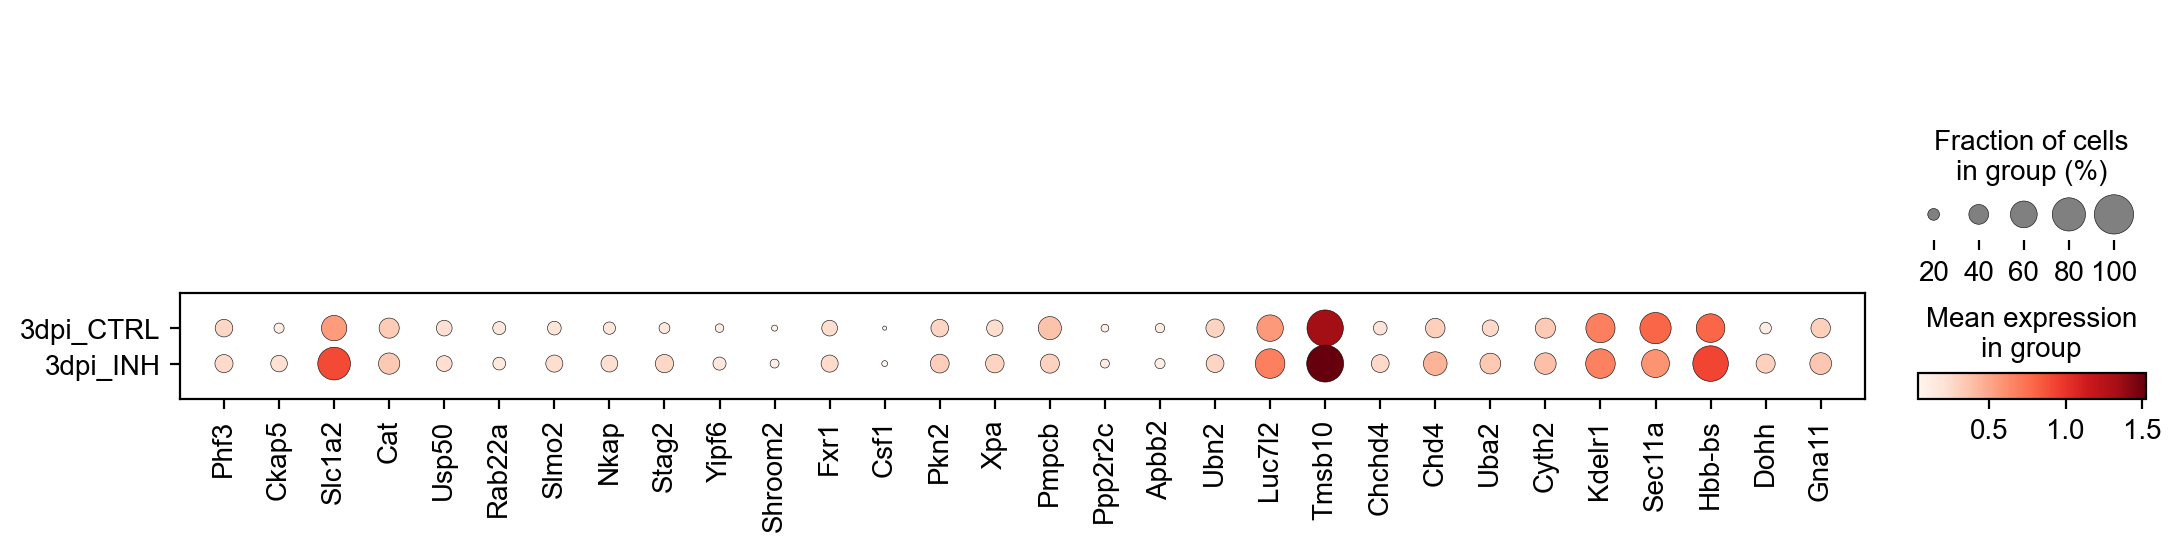

In [61]:
sc.pl.dotplot(adata_all_oligos_3dpi_OPCs1,oligos_3dpi_INH_MOL1['gene'].head(30) , groupby='condition',)

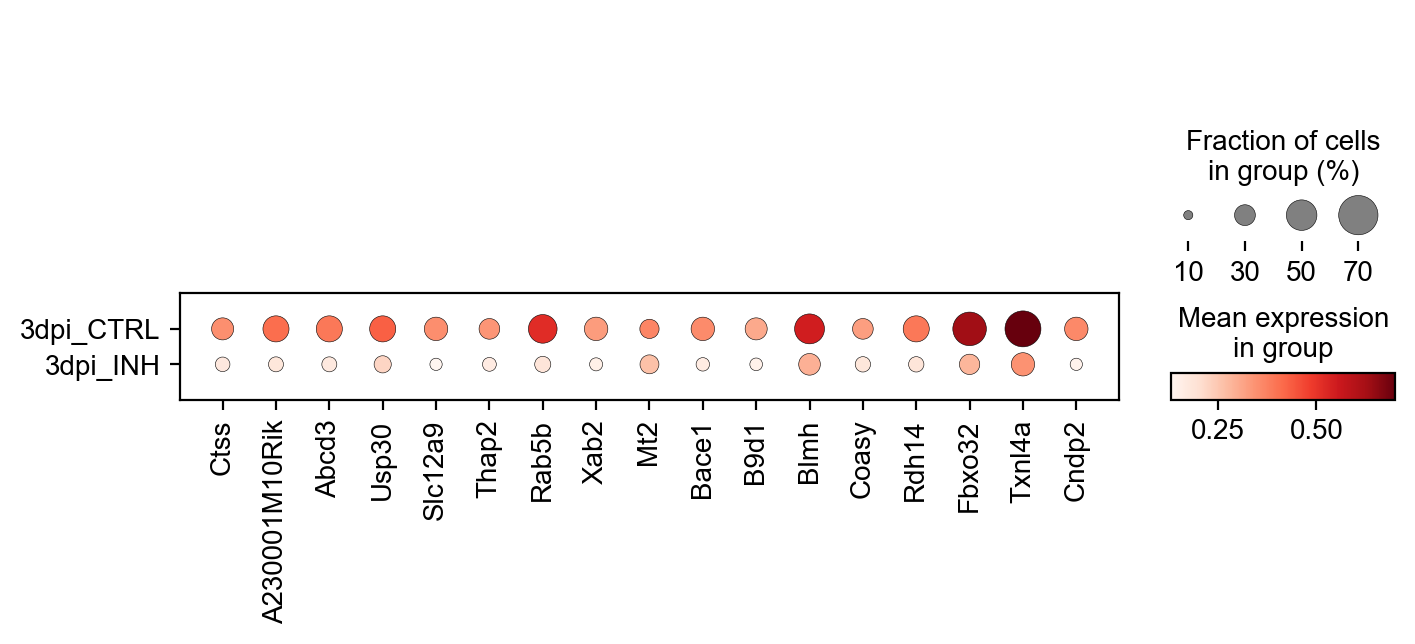

In [62]:
sc.pl.dotplot(adata_all_oligos_3dpi_MOL1,oligos_3dpi_CTRL_MOL1['gene'].head(30) , groupby='condition',)